## Importing Needed Libraries

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Reading The Data

In [2]:
data_dir = 'Tesla.csv'
df = pd.read_csv(data_dir, parse_dates= True , index_col= "Date")

## Data Exploration

In [3]:
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,18766300,23.889999
2010-06-30,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2010-07-01,25.000000,25.92,20.270000,21.959999,8218800,21.959999
2010-07-02,23.000000,23.10,18.709999,19.200001,5139800,19.200001
2010-07-06,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1692 entries, 2010-06-29 to 2017-03-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1692 non-null   float64
 1   High       1692 non-null   float64
 2   Low        1692 non-null   float64
 3   Close      1692 non-null   float64
 4   Volume     1692 non-null   int64  
 5   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 92.5 KB


In [5]:
df.describe()

,Open,High,Low,Close,Volume,Adj Close
count,1692.000000,1692.000000,1692.000000,1692.000000,1.692000e+03,1692.000000
mean,132.441572,134.769698,129.996223,132.428658,4.270741e+06,132.428658
std,94.309923,95.694914,92.855227,94.313187,4.295971e+06,94.313187
min,16.139999,16.629999,14.980000,15.800000,1.185000e+05,15.800000
25%,30.000000,30.650000,29.215000,29.884999,1.194350e+06,29.884999
50%,156.334999,162.370002,153.150002,158.160004,3.180700e+06,158.160004
75%,220.557495,224.099999,217.119999,220.022503,5.662100e+06,220.022503
max,287.670013,291.420013,280.399994,286.040009,3.716390e+07,286.040009


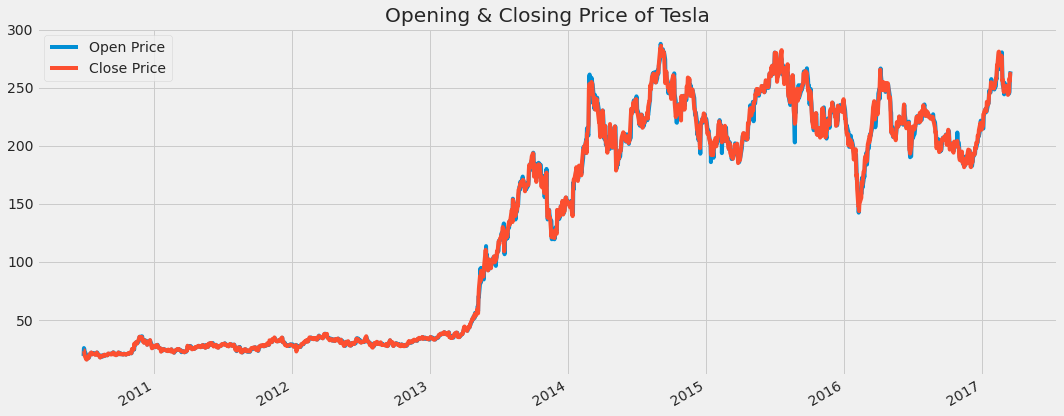

In [6]:
plt.figure(figsize=(15, 6))
df['Open'].plot()
df['Close'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Opening & Closing Price of Tesla")
plt.legend(['Open Price', 'Close Price'])
plt.tight_layout()
plt.show()

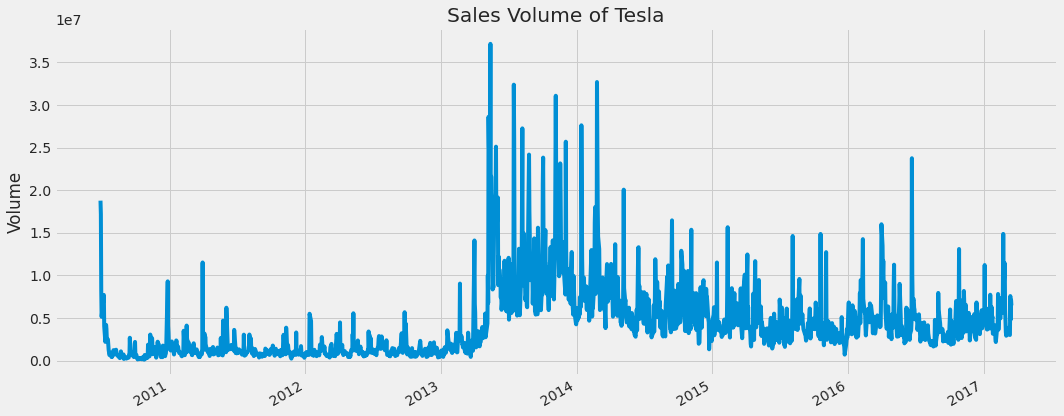

In [7]:
plt.figure(figsize=(15, 6))
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Sales Volume of Tesla")
plt.tight_layout()
plt.show()

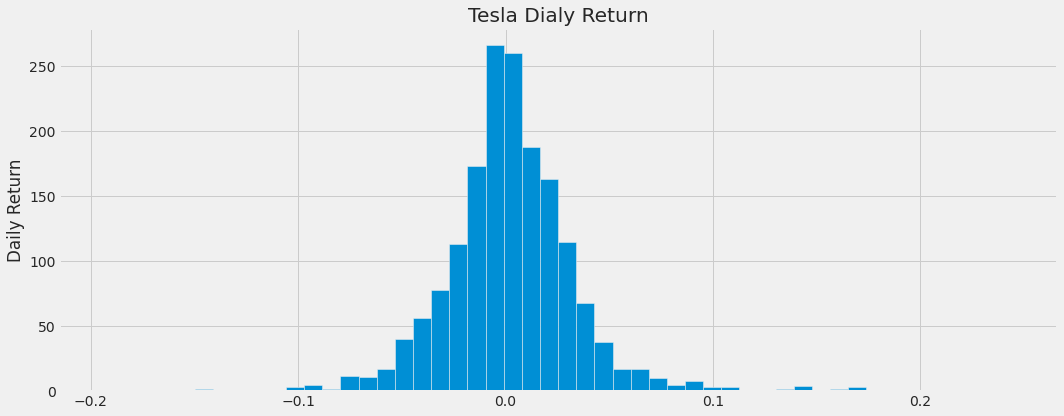

In [8]:
# We'll use pct_change to find the percent change for each day
plt.figure(figsize=(15, 6))
df['Adj Close'].pct_change().hist(bins=50)
plt.ylabel('Daily Return')
plt.title(f'Tesla Dialy Return')
plt.tight_layout()
plt.show()

## Data Preprocessing

### Choosing Prediction Column

In [9]:
dataset = df["Close"]
dataset = pd.DataFrame(dataset)

data = dataset.values

data.shape

(1692, 1)

### Normalizing Data

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

### Splitting the Data

In [12]:
# 75% to Train , 25% to Test
train_size = int(len(data)*.75)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size , 0:1 ]
test_data = scaled_data[ train_size-60: , 0:1 ]

Train Size : 1269 Test Size : 423


In [14]:
train_data.shape, test_data.shape

((1269, 1), (483, 1))

### Creating training set

In [15]:
# Creating a Training set with 60 time-steps and 1 output
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [16]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [18]:
x_train.shape , y_train.shape

((1209, 60, 1), (1209,))

## LSTM Model

### Model Dtructure

In [19]:
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], 1)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 42,465
Trainable params: 42,465
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [21]:
# Fitting the LSTM to the Training set
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32 , callbacks= callbacks )

Epoch 1/100
38/38 [==============================] - 5s 10ms/step - loss: 0.0203 - mean_absolute_error: 0.0910
Epoch 2/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_absolute_error: 0.0234
Epoch 3/100
38/38 [==============================] - 0s 9ms/step - loss: 0.0010 - mean_absolute_error: 0.0202
Epoch 4/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0010 - mean_absolute_error: 0.0201
Epoch 5/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0010 - mean_absolute_error: 0.0200
Epoch 6/100
38/38 [==============================] - 0s 8ms/step - loss: 9.6601e-04 - mean_absolute_error: 0.0196
Epoch 7/100
38/38 [==============================] - 0s 8ms/step - loss: 8.6324e-04 - mean_absolute_error: 0.0187
Epoch 8/100
38/38 [==============================] - 0s 8ms/step - loss: 0.0011 - mean_absolute_error: 0.0211
Epoch 9/100
38/38 [==============================] - 0s 8ms/step - loss: 9.4384e-04 - mean_absolute_error: 0.01

### Model Evaluation

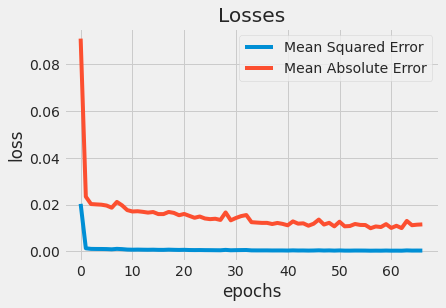

In [22]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Predection

### Creating testing set

In [23]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [24]:
x_test.shape , y_test.shape

((423, 60, 1), (423,))

In [25]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

14/14 [==============================] - 1s 5ms/step


(423, 1)

### Root mean square error

In [26]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

0.6

### Visualize Predictions with The Data

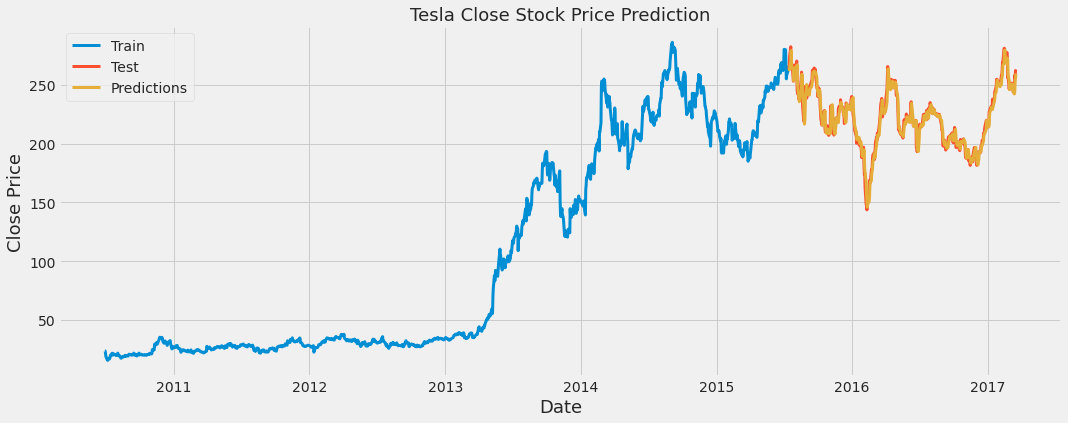

In [28]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Tesla Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close'], linewidth= 3)
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])